## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd

from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Описание задачи

**Бизнес-задача:**  
Разработать рекомендательную систему, с целью повысить прибыль от допродаж в интернет-магазине, на 20 %

**Техническая задача:**  
Разместить на главное странице сайта рекомендации товаров по идентификатору пользователя в трех местах.

* Создать сервис, выдающий рекомендации по идентификатору пользователя.
* Обёрнуть сервис в Docker.
* Написать документацию, описание функциональности.
* Сделать презентацию для менеджера с описанием принципов работы.

**Техническая метрика оценки качества:**  
Precision@3

## Описание данных

**events** — датасет с событиями. Колонки:
* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

**category_tree** — файл с деревом категорий (можно восстановить дерево).
* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

**item_properties** — файл с свойствами товаров.
* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

In [3]:
raw_data_events = pd.read_csv('data\events.csv')
raw_data_category = pd.read_csv('data\category_tree.csv')
raw_data_item_properties_1 = pd.read_csv('data\item_properties_part1.csv')
raw_data_item_properties_2 = pd.read_csv('data\item_properties_part2.csv')
raw_data_item_properties = pd.concat([raw_data_item_properties_1, raw_data_item_properties_2], ignore_index=True)

In [4]:
raw_data_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [5]:
raw_data_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [6]:
raw_data_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [7]:
raw_data_category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [8]:
raw_data_item_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


In [9]:
raw_data_item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [10]:
print(f'Количество уникальных свойств товаров: {raw_data_item_properties.property.nunique()}')
print(f'Перечень уникальных типов событий: {raw_data_events.event.unique()}')

Количество уникальных свойств товаров: 1104
Перечень уникальных типов событий: ['view' 'addtocart' 'transaction']


In [11]:
# кодирование стобца события
# 0 - просмотр + добавление в корзину
# 1 - покупка
raw_data_events['event_grade'] = raw_data_events['event'].apply(lambda x: 1 if x == 'transaction' else 0)
raw_data_events.event_grade.sum()

# преобразование типа данных признаков
raw_data_events['event'] = raw_data_events['event'].astype('category')
raw_data_item_properties['property'] = raw_data_item_properties['property'].astype('category')

In [12]:
# формирование временных признаков
raw_data_events['date'] = pd.to_datetime(raw_data_events['timestamp'], unit='ms', origin='unix')
raw_data_events['year'] = raw_data_events['date'].dt.year
raw_data_events['month'] = raw_data_events['date'].dt.month
raw_data_events['day_of_week'] = raw_data_events['date'].dt.day
raw_data_events['hour'] = raw_data_events['date'].dt.hour
raw_data_events.head()

,timestamp,visitorid,event,itemid,transactionid,event_grade,date,year,month,day_of_week,hour
0,1433221332117,257597,view,355908,NaN,0,2015-06-02 05:02:12.117,2015,6,2,5
1,1433224214164,992329,view,248676,NaN,0,2015-06-02 05:50:14.164,2015,6,2,5
2,1433221999827,111016,view,318965,NaN,0,2015-06-02 05:13:19.827,2015,6,2,5
3,1433221955914,483717,view,253185,NaN,0,2015-06-02 05:12:35.914,2015,6,2,5
4,1433221337106,951259,view,367447,NaN,0,2015-06-02 05:02:17.106,2015,6,2,5


In [13]:
print('Начальная точка датасета: ', raw_data_events['date'].min())
print('Конечная точка датасета: ', raw_data_events['date'].max())

Начальная точка датасета:  2015-05-03 03:00:04.384000
Конечная точка датасета:  2015-09-18 02:59:47.788000


In [14]:
# топ-3 по продажам до 1 июля включительно
mask_1 = raw_data_events['date'] <= '2015-07-02'
filter_1_events = raw_data_events[mask_1]
filter_1_events[filter_1_events['event'] == 'transaction'].itemid.value_counts()[0:3]

119736    36
369447    31
7943      30
Name: itemid, dtype: int64

In [15]:
# поиск процента продаж
mask_2 = raw_data_events['date'] > '2015-07-02'
filter_2_events = raw_data_events[mask_2]
n_top_transactions = filter_2_events[((filter_2_events['itemid'] == 119736)|(filter_2_events['itemid'] == 369447) | (filter_2_events['itemid'] == 7943)) & (filter_2_events['event'] == 'transaction')].shape[0]
n_transactions = filter_2_events[filter_2_events['event'] == 'transaction'].shape[0]
percent_of_top_items = np.round((n_top_transactions / n_transactions * 100), 2)
print(f'Процент продаж топовых продуктов за период до 2 июля 2015 года = {percent_of_top_items}%')

Процент продаж топовых продуктов за период до 2 июля 2015 года = 0.61%


## Exploratory data analysis

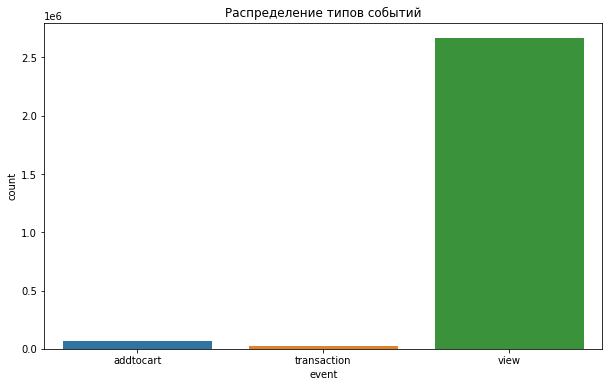

In [16]:
# распределение типов событий
plt.figure(figsize=(10, 6))
sns.countplot(data=raw_data_events, x='event')
plt.title('Распределение типов событий')
plt.show()

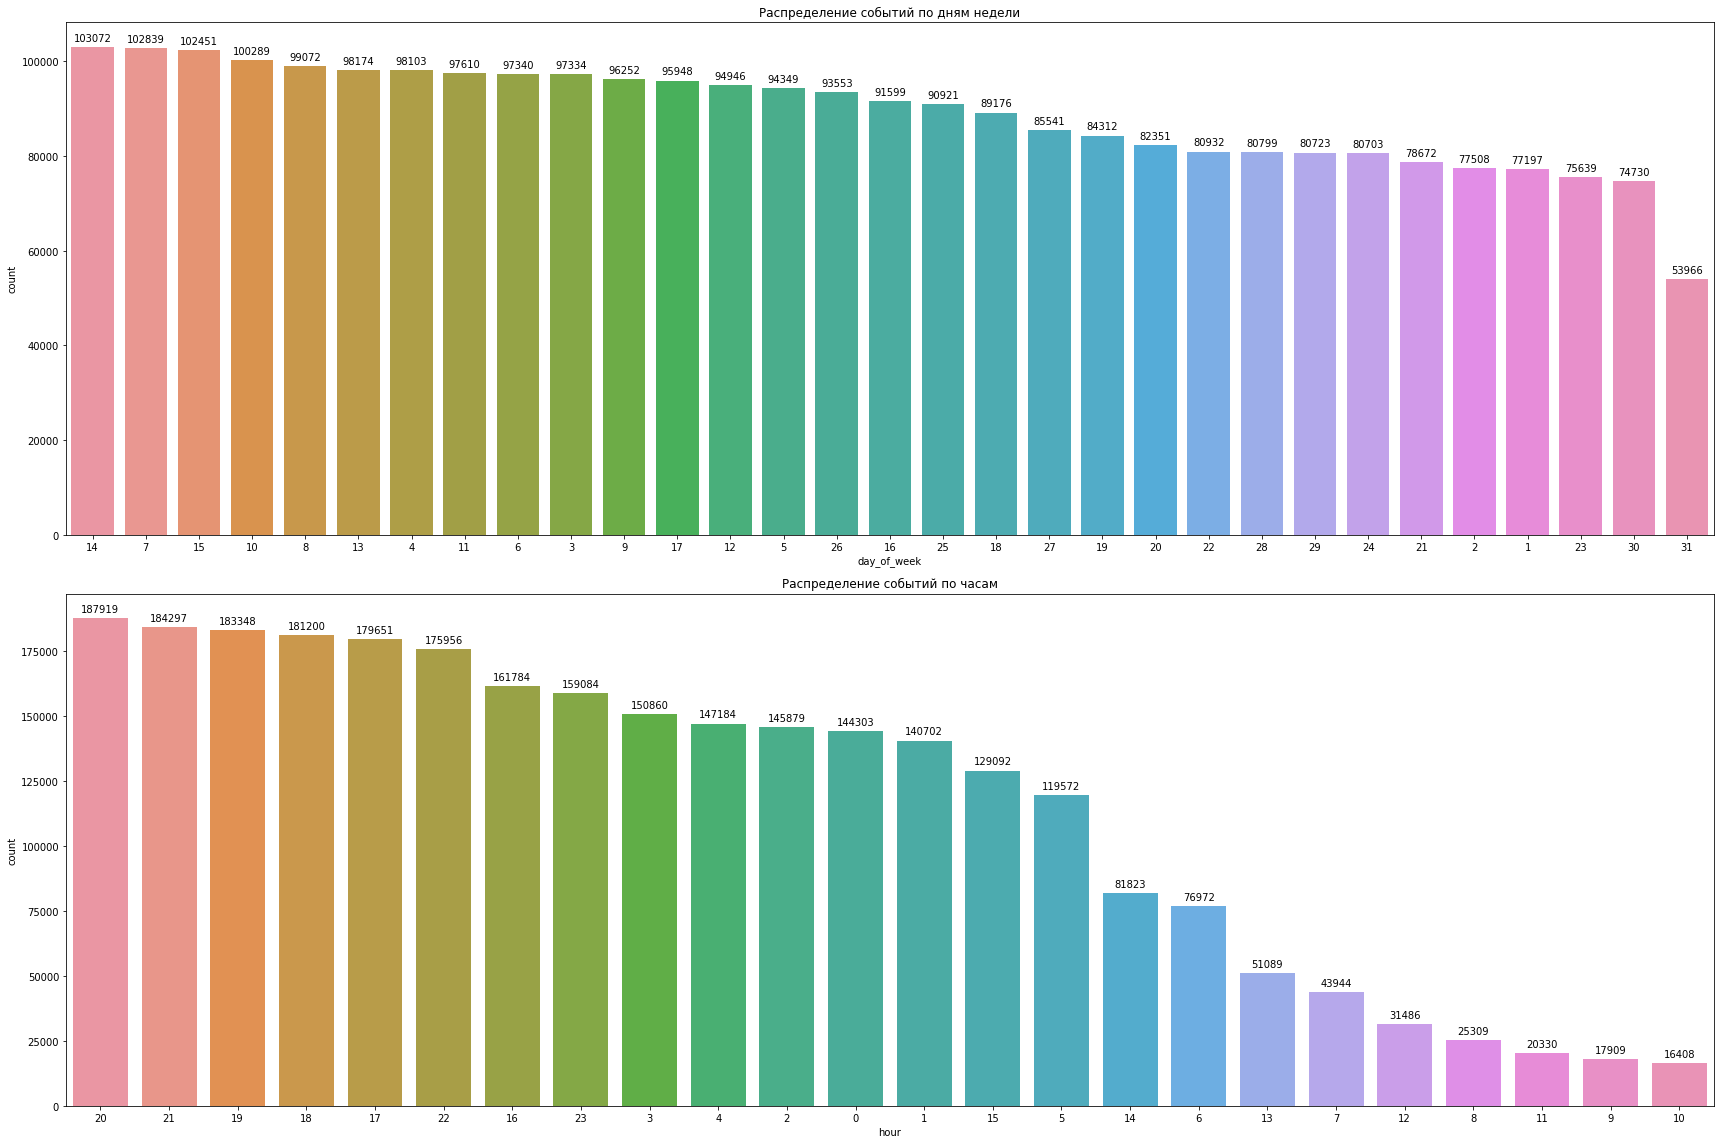

In [17]:
# распределение событий по дням недели и часам дня
plt.figure(figsize=(24, 16))

plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=raw_data_events, x='day_of_week', order=raw_data_events['day_of_week'].value_counts().index)
plt.title('Распределение событий по дням недели')
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.subplot(2, 1, 2)
ax2 = sns.countplot(data=raw_data_events, x='hour', order=raw_data_events['hour'].value_counts().index)
plt.title('Распределение событий по часам')
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.show()

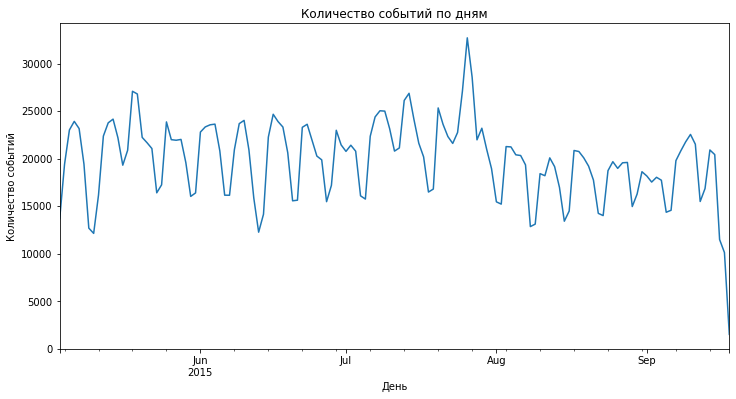

In [18]:
# распределение количества событий по дням
events_by_days = raw_data_events.resample('D', on='date').count()

plt.figure(figsize=(12, 6))
events_by_days['event'].plot()
plt.title('Количество событий по дням')
plt.xlabel('День')
plt.ylabel('Количество событий')
plt.show()

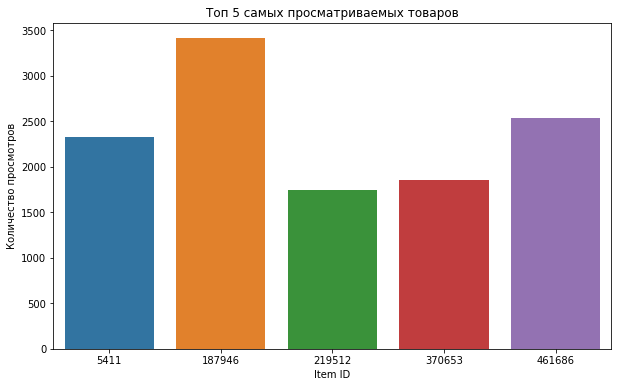

In [19]:
# топ 5 товаров по просмотрам
top_5_viewed_items = raw_data_events[raw_data_events['event'] == 'view']['itemid'].value_counts().head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_viewed_items.index, y=top_5_viewed_items.values)
plt.title('Топ 5 самых просматриваемых товаров')
plt.xlabel('Item ID')
plt.ylabel('Количество просмотров')
plt.show()

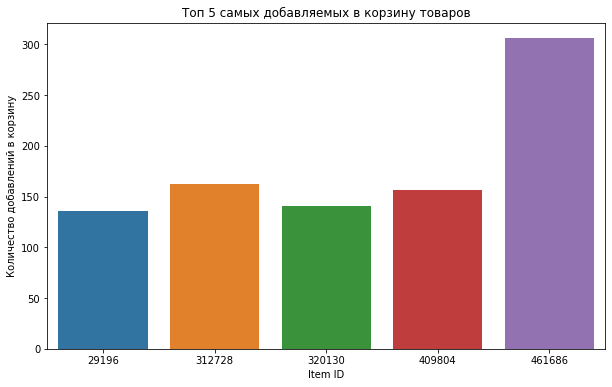

In [20]:
# топ 5 товаров по добавлениям в корзину
top_5_added_items = raw_data_events[raw_data_events['event'] == 'addtocart']['itemid'].value_counts().head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_added_items.index, y=top_5_added_items.values)
plt.title('Топ 5 самых добавляемых в корзину товаров')
plt.xlabel('Item ID')
plt.ylabel('Количество добавлений в корзину')
plt.show()

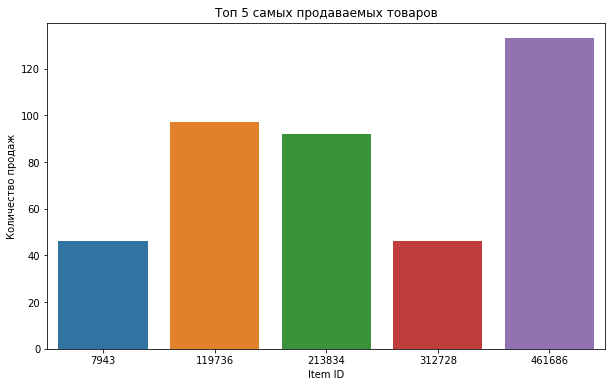

In [21]:
# топ 5 товаров по продажам
top_5_sold_items = raw_data_events[raw_data_events['event'] == 'transaction']['itemid'].value_counts().head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_sold_items.index, y=top_5_sold_items.values)
plt.title('Топ 5 самых продаваемых товаров')
plt.xlabel('Item ID')
plt.ylabel('Количество продаж')
plt.show()

## Feature engineering

In [22]:
# Удаление дубликатов
data_events = raw_data_events.drop_duplicates(keep='first').reset_index(drop=True)

In [23]:
# разделелие юзеров по признаку совершения покупки
# список идентификаторов юзеров
all_visitors = data_events.visitorid.sort_values().unique() 
# список только тех юзеров, которые совершили покупку
purchase_visitors = data_events[data_events.event == 'transaction'].visitorid.sort_values().unique()
# список юзеров, которые не совершали покупку
view_visitors = list([x for x in all_visitors if x not in purchase_visitors])

In [24]:
# генерация признаков классическим методом

# объединение датасета событий со свойствами товаров и родительской категорией
merged_events = data_events.merge(raw_data_item_properties[raw_data_item_properties['property'] == 'categoryid'][['itemid', 'property', 'value']], on='itemid', how='left')
merged_events['value'] = merged_events['value'].astype('float')
merged_events = merged_events.merge(raw_data_category, left_on='value', right_on='categoryid', how='left')
display(merged_events)

# user_based признаки
user_based_features = merged_events.groupby('visitorid').agg({
    'itemid':'count',
    'categoryid': 'nunique',
    'parentid': 'nunique',
    'event_grade': 'sum'
}).reset_index()

user_based_features.columns = ['visitorid', 'item_count_interaction', 'category_count_interaction', 'parent_category_count_interaction', 'amount_of_transactions']
display(user_based_features)

# item_based признаки
item_based_features = merged_events.groupby('itemid').agg({
    'visitorid':'count',
     'event': ['nunique',
                lambda x: sum(x == 'view'),
                lambda x: sum(x =='addtocart'),
                lambda x: sum(x =='transaction')]
   }).reset_index()

item_based_features.columns=['itemid','user_count','event_count','view_count','addtocart_count','transaction_count']
item_based_features['conversion rate'] = item_based_features['transaction_count']/item_based_features['addtocart_count']
display(item_based_features)

,timestamp,visitorid,event,itemid,transactionid,event_grade,date,year,month,day_of_week,hour,property,value,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,0,2015-06-02 05:02:12.117,2015,6,2,5,categoryid,1173.0,1173.0,805.0
1,1433224214164,992329,view,248676,NaN,0,2015-06-02 05:50:14.164,2015,6,2,5,categoryid,1231.0,1231.0,901.0
2,1433221999827,111016,view,318965,NaN,0,2015-06-02 05:13:19.827,2015,6,2,5,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,0,2015-06-02 05:12:35.914,2015,6,2,5,categoryid,914.0,914.0,226.0
4,1433221337106,951259,view,367447,NaN,0,2015-06-02 05:02:17.106,2015,6,2,5,categoryid,1613.0,1613.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5899100,1438398785939,591435,view,261427,NaN,0,2015-08-01 03:13:05.939,2015,8,1,3,categoryid,1623.0,1623.0,1066.0
5899101,1438399813142,762376,view,115946,NaN,0,2015-08-01 03:30:13.142,2015,8,1,3,categoryid,1616.0,1616.0,827.0
5899102,1438397820527,1251746,view,78144,NaN,0,2015-08-01 02:57:00.527,2015,8,1,2,categoryid,969.0,969.0,1141.0
5899103,1438398530703,1184451,view,283392,NaN,0,2015-08-01 03:08:50.703,2015,8,1,3,categoryid,1589.0,1589.0,1426.0


,visitorid,item_count_interaction,category_count_interaction,parent_category_count_interaction,amount_of_transactions
0,0,3,3,2,0
1,1,1,1,1,0
2,2,8,2,1,0
3,3,1,1,1,0
4,4,1,0,0,0
...,...,...,...,...,...
1407575,1407575,1,1,1,0
1407576,1407576,1,1,1,0
1407577,1407577,1,1,1,0
1407578,1407578,1,1,1,0


,itemid,user_count,event_count,view_count,addtocart_count,transaction_count,conversion rate
0,3,2,1,2,0,0,NaN
1,4,3,1,3,0,0,NaN
2,6,29,1,29,0,0,NaN
3,9,2,1,2,0,0,NaN
4,15,22,3,18,3,1,0.333333
...,...,...,...,...,...,...,...
235056,466861,95,3,89,5,1,0.200000
235057,466862,4,1,4,0,0,NaN
235058,466863,1,1,1,0,0,NaN
235059,466864,91,2,89,2,0,0.000000


In [25]:
# генерация item-based признаков при помощи алгоритма ALS
# cоздание разреженной матрицы item-user
#merged_events['event_value'] = (merged_events['event'] == 1).astype(int)
item_user_matrix = coo_matrix((merged_events['event_grade'], (merged_events['itemid'], merged_events['visitorid']))).tocsr()


# инициализация ALS модели
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50)

# обучение модели ALS
als_model.fit(item_user_matrix)

# получение факторов для айтемов
item_factors = als_model.item_factors

# создание DataFrame с факторами айтемов
item_factors_df = pd.DataFrame(item_factors, index=range(1, item_factors.shape[0] + 1), columns=[f'item_factor_{i}' for i in range(item_factors.shape[1])])

# добавление факторов айтемов к исходному датасету
merged_events = pd.merge(merged_events, item_factors_df, left_on='itemid', right_index=True, how='left')

merged_events.head(3)

  0%|          | 0/50 [00:00<?, ?it/s]

,timestamp,visitorid,event,itemid,transactionid,event_grade,date,year,month,day_of_week,...,item_factor_40,item_factor_41,item_factor_42,item_factor_43,item_factor_44,item_factor_45,item_factor_46,item_factor_47,item_factor_48,item_factor_49
0,1433221332117,257597,view,355908,NaN,0,2015-06-02 05:02:12.117,2015,6,2,...,6.517866e-13,2.379301e-13,5.633282e-13,-2.712996e-12,-3.011259e-12,1.496858e-13,-6.797607e-13,-7.780013e-13,-2.389320e-12,2.826406e-12
1,1433224214164,992329,view,248676,NaN,0,2015-06-02 05:50:14.164,2015,6,2,...,2.503744e-12,-3.825717e-12,-9.236652e-13,2.472254e-12,1.403651e-13,-3.196179e-13,1.706209e-12,-1.356783e-12,2.880140e-12,-2.533004e-12
2,1433221999827,111016,view,318965,NaN,0,2015-06-02 05:13:19.827,2015,6,2,...,-3.408421e-12,4.059466e-12,-3.062687e-12,1.043463e-12,3.517029e-12,-1.033447e-12,-1.561956e-12,-4.985837e-13,-2.538707e-12,5.272683e-12


In [26]:
# генерация item-user признаков при помощи алгоритма ALS
# создание разреженной матрицы user-item в формате CSR посредством транспонирования
user_item_matrix = coo_matrix((merged_events['event_grade'], (merged_events['visitorid'], merged_events['itemid']))).T.tocsr()

# инициализация ALS модели для user-item матрицы
als_user_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50)

# обучение модели ALS для user-item матрицы
als_user_model.fit(user_item_matrix)

# получение факторов для пользователей
user_factors = als_user_model.user_factors

# создание DataFrame с факторами пользователей
user_factors_df = pd.DataFrame(user_factors, index=range(1, user_factors.shape[0] + 1), columns=[f'user_factor_{i}' for i in range(user_factors.shape[1])])

# добавление факторов пользователей к исходному датасету
merged_events = pd.merge(merged_events, user_factors_df, left_on='visitorid', right_index=True, how='left')

merged_events.head(3)

  0%|          | 0/50 [00:00<?, ?it/s]

,timestamp,visitorid,event,itemid,transactionid,event_grade,date,year,month,day_of_week,...,user_factor_40,user_factor_41,user_factor_42,user_factor_43,user_factor_44,user_factor_45,user_factor_46,user_factor_47,user_factor_48,user_factor_49
0,1433221332117,257597,view,355908,NaN,0,2015-06-02 05:02:12.117,2015,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1433224214164,992329,view,248676,NaN,0,2015-06-02 05:50:14.164,2015,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1433221999827,111016,view,318965,NaN,0,2015-06-02 05:13:19.827,2015,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# разделение на тренировочный и валидационные датасеты
mask_train = merged_events['date'] <= '2015-08-18'
mask_val = merged_events['date'] > '2015-08-18' # принят последний месяц

train_data_events = merged_events[mask_train]
val_data_events = merged_events[mask_val]

print(f'Количество событий в тренировочном датасете: {train_data_events.shape[0]}')
print(f'Количество событий в валидационном датасете: {val_data_events.shape[0]}')

Количество событий в тренировочном датасете: 4783238
Количество событий в валидационном датасете: 1115867
